In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from sys import platform
from copy import deepcopy as dc
from scipy.interpolate import interp1d

vims_wave = np.loadtxt('vims_wave.txt')

new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
if platform == 'darwin' or platform == 'win32' or platform == 'linux':
    for number in new_array:
        new_string = 'df'+number+' = pd.read_pickle("c_data/data'+number+'.pkl")'
        exec(new_string)
else:
    df_list = []
    for number in new_array:
        new_string = 'df'+number+' = pd.read_csv("c_data/data'+number+'.csv")'
        exec(new_string)
        df_list.append(locals()['df'+number])
    for df in df_list:
        for i in range(len(df['spectrum'])):
            df['spectrum'][i] = np.array([float(x) for x in df['spectrum'][i][1:-1].split(',')])

vims_list = []
for number in new_array:
    exec('vims'+number+' = np.average([np.load("vims_shift/vims_20'+number[1:3]+'.npy"),np.load("vims_shift/vims_20'+number[3:5]+'.npy")],axis=0)')
    vims_list.append(locals()['vims'+number])

def powerlaw(x,a,b):
    return a*np.power(x,b)

def gaussian(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def flatten(some_list):
    flat_list = []
    for element in some_list:
        if type(element) is list or type(element) is tuple:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

band_channels = list(chain(range(29,35),range(46,60),range(78,96),range(102,106)))

window = list(range(56,83))

def fit_line(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def custom_fit(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_spectra = spectra-powerlaw(vims_wave,*my_fit)
    return final_spectra

def single_fit(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_spectrum = spectrum-powerlaw(vims_wave,*my_fit)
    return final_spectrum

def shift_ret(spectrum):
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2.05])
    return my_fit[1]

In [3]:
scatter_list = []
for number in new_array:
    my_string = 'scatter'+number+" = df"+number
    exec(my_string)
    scatter_list.append(locals()['scatter'+number])

total_scatter = pd.concat(scatter_list)

all_spectra = total_scatter['spectrum']

averaged_total = np.average(all_spectra)

spec_list = []
for number in new_array:
    my_string = 'old_spec'+number+' = df'+number+"['spectrum']"
    exec(my_string)
    exec('inc'+number+' = np.asarray(df'+number+"['incidence'])")
    exec('em'+number+' = np.asarray(df'+number+"['emission'])")
    new_string = 'spec'+number+' = np.array([np.abs(x) for x in old_spec'+number+'])'
    exec(new_string)
    spec = 'spec'+number
    spec_list.append(locals()[spec])

sf = np.pi/180
averaged_list = []
for number in new_array:
    exec('spec'+number+' /= (np.cos(inc'+number+'*sf))/(np.cos(inc'+number+'*sf)+np.cos(em'+number+'*sf))[None,:]')
    my_string = 'averaged'+number+' = np.average(spec'+number+',axis=0)'
    exec(my_string)
    averaged_list.append(locals()['averaged'+number])

copy_list = []
for number in new_array:
    my_string = 'copy_spec'+number+' = dc(spec'+number+')'
    exec(my_string)
    copy_spec = 'copy_spec'+number
    copy_list.append(locals()[copy_spec])

for (spec,copy_spec) in zip(spec_list,copy_list):
    for i in range(256):
        filtered = False
        k = 0
        while filtered == False:
            mean_1 = np.mean(copy_spec[:,i])
            median = np.median(copy_spec[:,i])
            std = np.std(copy_spec[:,i])
            vals = copy_spec[:,i]
            ind = np.where(np.abs(vals-mean_1)>2*std)
            copy_spec[ind,i] = median
            mean_2 = np.mean(copy_spec[:,i])
            k += 1
            if np.abs(mean_1-mean_2) <=.05*mean_1:
                filtered = True

pList_total = []
for (copy_spec,number) in zip(copy_list,new_array):
    exec('pList'+number+' = []')
    for spec in copy_spec:
        new_spec = single_fit(spec)
        final_spec = np.abs(new_spec)
        locals()['pList'+number].append(final_spec)
    pList_total.append(locals()['pList'+number])



ValueError: operands could not be broadcast together with shapes (2507,256) (1,2507) (2507,256) 

In [ ]:
total_scatter

,fileid,lineres,emission,incidence,latitude,longitude,spectrum
0,19779,62097.681413,30.881187,39.996733,10.408238,309.431710,"[0.0627468, 0.0772501, 0.115962, 0.158278, 0.1..."
1,73581,15042.961556,30.017625,39.995293,10.798510,305.135524,"[0.0649121, 0.0794369, 0.119561, 0.161287, 0.1..."
2,73581,15275.300926,33.924880,39.988389,13.097070,301.397352,"[0.0686598, 0.0839468, 0.126895, 0.169983, 0.1..."
3,73581,15519.941008,34.936784,39.987750,13.601726,300.441459,"[0.0683702, 0.0855701, 0.127764, 0.171474, 0.1..."
4,73581,13934.837773,31.017054,39.983581,11.435282,304.167414,"[0.0649137, 0.0816108, 0.120783, 0.164939, 0.1..."
...,...,...,...,...,...,...,...
1270,27343,38414.199284,31.189751,20.247050,12.489629,310.872401,"[0.0603998, 0.103166, 0.163553, 0.156522, 0.09..."
1271,27864,37707.637871,25.783813,20.176448,9.217981,315.052787,"[0.0590715, 0.100256, 0.157004, 0.149544, 0.09..."
1272,27650,37434.752350,25.709792,20.136072,9.204018,315.129655,"[0.059886, 0.100492, 0.15705, 0.1499, 0.096029..."
1273,59077,49468.523178,32.391633,20.104393,10.177082,315.082358,"[0.0598412, 0.10206, 0.160232, 0.15152, 0.0967..."


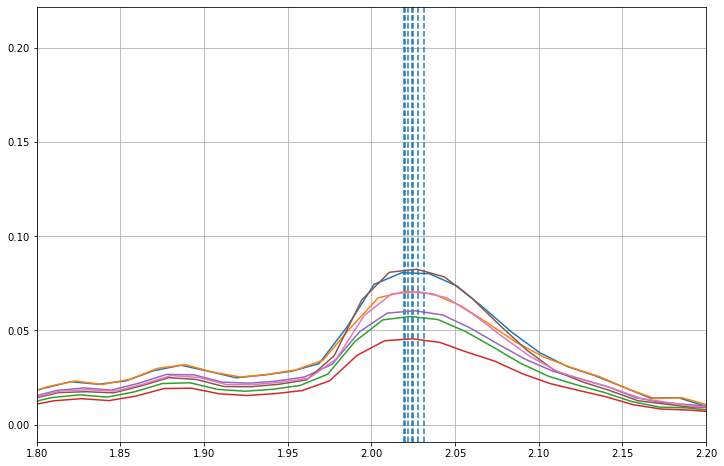

In [ ]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(12,8))
for vims,spectrum in zip(vims_list,averaged_list):
    my_fit,_ = curve_fit(gaussian,vims[window],spectrum[window],p0=[.05,2.025,.05])
    plt.axvline(x=my_fit[1],linestyle='--')
    plt.plot(vims,spectrum)
plt.xlim([1.8,2.2])
plt.grid()
plt.show()

In [ ]:
spec_0405 /= np.cos(np.asarray(inc_0405)*(np.pi/180))[:,None]

In [ ]:
sf = np.pi/180
spec_0405 = (np.cos(inc_0405*sf))/(np.cos(inc_0405*sf)+np.cos(em_0405*sf))

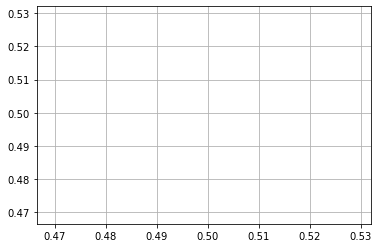

In [ ]:
for spectrum in copy_spec_0405:
    plt.plot(spectrum,spectrum)
plt.grid()
plt.show()